A.S. Lundervold, v260922

# Introduction

In this notebook, we'll study **decision trees**. Why?
1. They form the basis for some of the most powerful methods in all of machine learning
2. They produce highly interpretable models, which is useful in contexts where you need high explainability (law, finance, medicine, and much more).

## Overview

- We'll first introduce decision trees: what they are, and how they can be trained (or "grown") using the so-called CART algorithm.



- We'll also see that they can produce highly complex decision boundaries when used for classification, which makes them capable of fitting very complicated training data sets. 



- We'll see how decision trees can be used for both classification and regression. 



- We'll also see that they often tend to overfit, motivating an extension to models with less variance through ensembling. This will result in the *random forests* models discussed in the next notebook. 

<img src="https://github.com/alu042/DAT158-2022/raw/main/notebooks/assets/decision_tree_cancer.png">

# Setup

We need our standard framework:

In [2]:
# To display plots directly in the notebook:
%matplotlib inline

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

In [5]:
# Set the directory in which to store data
NB_DIR = Path.cwd()  # Set NB_DIR to be the current working directory
DATA = NB_DIR / 'data'  # The data dir is the subdirectory 'data' under NB_DIR

DATA.mkdir(exist_ok=True)  # Create the data directory

In [6]:
import warnings

warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Decision trees

From a set of labelled data, a classification tree learns a set of if-else questions about the features and is used to predict the labels. 

To be concrete, let's use the diabetes data set studied in previous notebooks. First, we load it as before:

In [7]:
import urllib.request

url = 'https://assets.datacamp.com/production/course_1939/datasets/diabetes.csv'
urllib.request.urlretrieve(url, DATA / 'diabetes.csv')

(PosixPath('/home/martin/git/python/DAT158-2023/notebooks/data/diabetes.csv'),
 <http.client.HTTPMessage at 0x7fd8ec542e10>)

In [8]:
diabetes = pd.read_csv(DATA / 'diabetes.csv')

It has 8 features and a binary label (diabetes vs. not diabetes):

In [9]:
diabetes.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


We restrict ourselves to two features for easier visualization:

In [10]:
data = diabetes[['glucose', 'bmi', 'diabetes']]

Here's a scatter plot of the data we have, with glucose levels plotted against bmi and the dots colored by whether the person has diabetes or not:

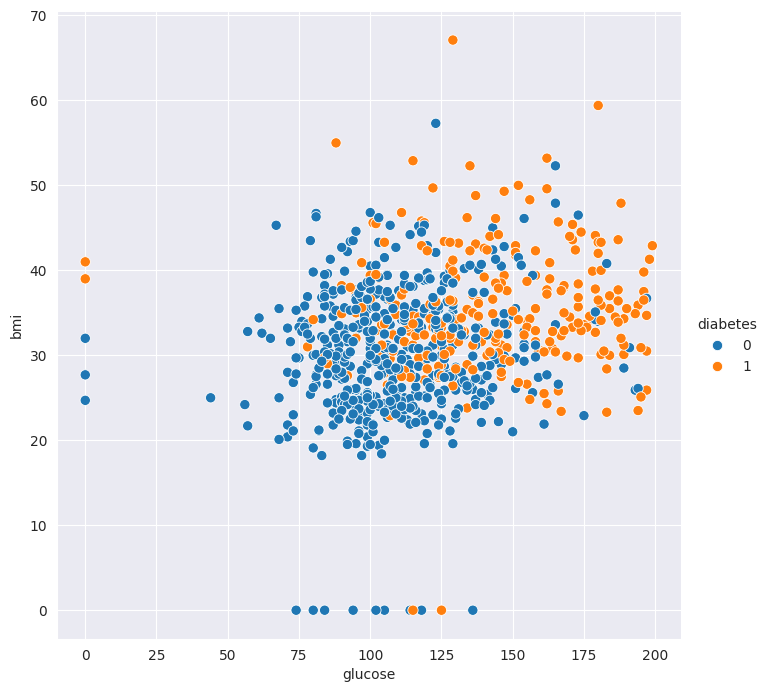

In [11]:
sns.pairplot(x_vars='glucose', y_vars='bmi', data=data, hue='diabetes',
             height=7,
             plot_kws={"s": 55}  # Size of markers
             )
plt.show()

We notice that diabetes instances tend to have higher blood glucose levels and higher body mass index.

To decide whether a person has diabetes, we could therefore make a set of rules saying things like

- "If your glucose level is above 125 *and* your BMI is above 30, predict diabetes."
- "If glucose below 150 _and_ BMI above 40, then predict diabetes"
- and so on...

> Such a set of rules is precisely a **decision tree**.

Let's use scikit-learn to make the rules and the tree for us:

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
#?DecisionTreeClassifier

In [14]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=seed)  # We'll discuss `max_depth=2` soon

In [15]:
X = data[['glucose', 'bmi']]  # The features
y = data['diabetes']  # The labels

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed)

In [18]:
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

...and plot it:

> **Note: you need graphviz https://graphviz.gitlab.io/download/ on your computer for the below plotting to work.** If you don't want to install graphviz or you're using Colab, you can simply run the cell with `IPython.display.Image` below to load a pre-computed version.

In [19]:
!{sys.executable} -m pip install graphviz
from graphviz import Source

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 2.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [20]:
from IPython.display import display
from IPython.display import SVG

In [21]:
from sklearn.tree import export_graphviz

In [22]:
graph = Source(export_graphviz(tree_clf, out_file=None, feature_names=X.columns,
                               class_names=['not diabetes', 'diabetes'], filled=True, rounded=True))

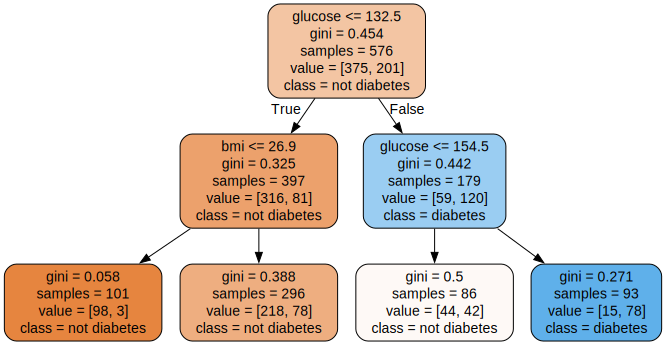

In [23]:
# The following requires graphviz on your computer
display(SVG(graph.pipe(format='svg')))

*Run the below cell if you couldn't get the above plot to work:*

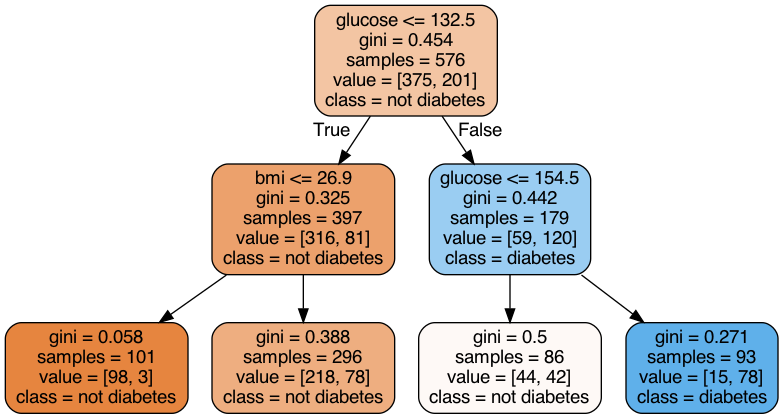

In [24]:
from IPython.display import Image, display

display(Image("https://raw.githubusercontent.com/alu042/DAT158-2022/master/notebooks/assets/decision_tree_diabetes.png",
              width=90))

We see that we get something that can be used to make predictions. If you're tasked with diagnosing diabetes or not diabetes for an instance based on this decision tree, you do as follows:

- Start at the root node. If the glucose level is 132.5 or below, take the path on the left. Else take the path on the right.
- If you took the left path, then you look at the BMI. 
    - If BMI is less than 26.9, take the next left path. You end at a **leaf node** (a node where you can't go further). Your prediction is then `class = not diabetes`. 
    - If the BMI is larger than 26.9, take the right path. You end at another leaf node and make the prediction `class = not diabetes`.
- If you took the right path, then you again look at the glucose.
    - If glucose is less than 154.5, you take the left path. You end up at a leaf node and make the prediction `class = not diabetes`
    - If glucose is larger than 154.5, you take the right path, end up at a leaf node, and make the prediction `class = diabetes`.

This is exactly how predictions are made if you run `tree_clf.predict`. Each instance is fed through the tree according to its features until it hits a leaf node, where the class is assigned.

> What are the other terms listed inside the nodes? "Gini", "samples", "value", what do they mean?

> And how did scikit-learn construct the decision tree?

> **Your turn!** <br>- How accurate is our classifier on the test set?<br>- Try creating a decision tree with `max_depth=3` and interpret the resulting tree as we did above.

## Decision trees glossary

- **Root node**: The top-most node. No parent node. Where you start. Poses the first if-else question.


- **Internal node**: Has one parent node and two children. These nodes pose if-else questions.


- **Leaf node**: A node without children. Not possible to go any further. A bottom node. These nodes provide predictions.


- **`samples`**: The number of training samples that the node applies to. The number of training instances that end up passing through the node. For example, there are 179 samples for which the glucose is less than 154.5


- **`value`**: A list of the number of samples *of each class* that the node applies to. 


- **`gini`**: A measure of "impurity". The gini is 0 if all the training samples in that node belongs to a single class. It grows towards 1 as the class diversity at the node increases. 

We'll have more to say about the Gini impurity shortly, as it's what's used to make decision trees.

But first, it's instructive to visualize the decision boundary produced by our decision tree:

## Decision boundaries for decision trees

In [25]:
!wget https: // raw.githubusercontent.com/alu042/DAT158-2022 /master/notebooks/utils.py

--2023-10-29 13:33:57--  ftp://https/
           => ‘.listing’
Resolving https (https)... failed: Name or service not known.
wget: unable to resolve host address ‘https’
//: Scheme missing.
--2023-10-29 13:33:57--  http://raw.githubusercontent.com/alu042/DAT158-2022
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/alu042/DAT158-2022 [following]
--2023-10-29 13:33:58--  https://raw.githubusercontent.com/alu042/DAT158-2022
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 400 Bad Request
2023-10-29 13:33:58 ERROR 400: Bad Request.

/master/notebooks/utils.py: Sch

In [26]:
# We use a custom function for plotting the decision boundary. 
# Have a look at the file `utils.py` if you're curious about how it's made.
from utils import plot_decision_boundary

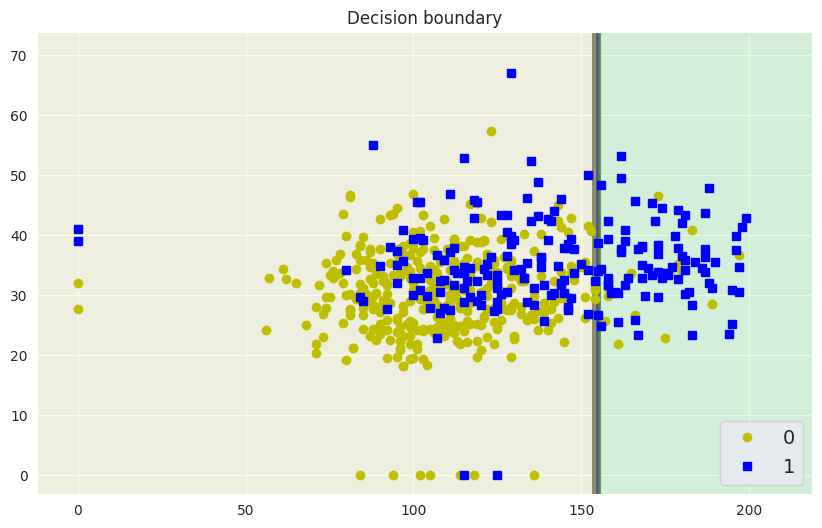

In [27]:
_ = plot_decision_boundary(tree_clf, X_train, y_train)

Let's plot the decision boundary for a tree with `max_depth=3`:

In [28]:
tree_clf_d3 = DecisionTreeClassifier(max_depth=3, random_state=seed)

In [29]:
tree_clf_d3.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

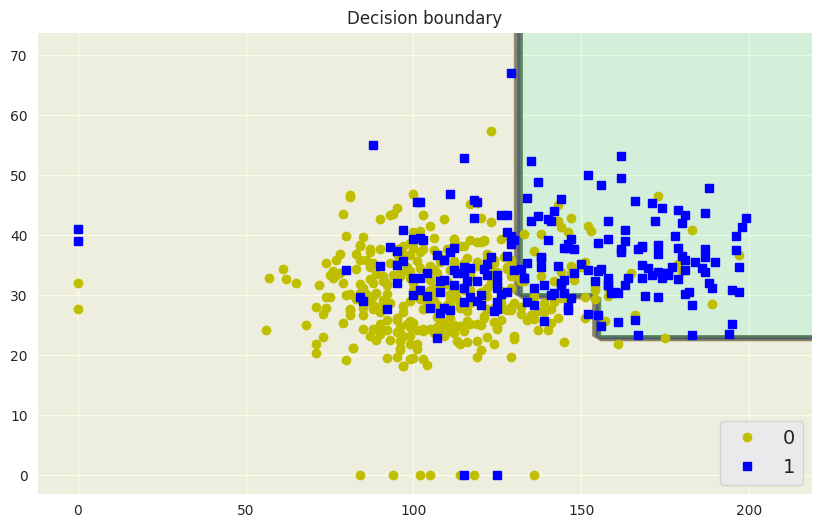

In [30]:
_ = plot_decision_boundary(tree_clf_d3, X_train, y_train)

Note that the boundary is **not linear**. It is not a straight line and is not smooth.

**Note:** The decision boundaries of decision trees are always parallel to an axis. Why is that? It's because each node in a decision tree consists of a test using only **one feature at a time**. 

> **Your turn!** 
- Create a function that plots the decision boundary for a classifier with a specified `max_depth`. Note that the decision boundary gets more complex as you increase `max_depth`. That should make us fear overfitting...
- Compute the decision boundary for a different pair of features. That is, not (`glucose`, `bmi`), but something else.

## Gini and information gain

By organizing the training data in a binary tree, decision trees learn the relationship between the training data and the corresponding labels. Each leaf in the tree makes a specific prediction. Each internal node compares a single feature value against a single threshold and places instances in their corresponding child nodes. 

Training a decision tree is done recursively, roughly as follows (we'll study training more carefully below): 

* The goal is to obtain leaves that are as pure as possible, with the maximum amount of samples in the leaves belonging to the same class.
* Starting at the root node, the data is split into two parts based on the feature that has the largest **information gain**. 
* This is repeated for each child of the node and so on, iteratively.


To achieve this, we need a measure of information gain, and we also need it to tell us when a node is pure.

**Gini impurity** is one such measure:

$$G_i = 1 - \sum_{k=1}^n p_{i,k}^2 $$

Here $p_{i,k}$ is the proportion of the samples that belong to class $k$ for the node $i$. 

We note that:
- If the node is **pure**, that is, all the samples belong to a single class, then $G_i$ = 0. 
- If a node has many samples belonging to each of many classes, then $G_i$ gets closer to 1. Very impure.
- The **information gain** of a node can be computed as the Gini impurity at the node minus the sum of the Gini impurity of its children weighted by their sizes relative to the parent node. 

Let's try out the formula for the tree we found above:

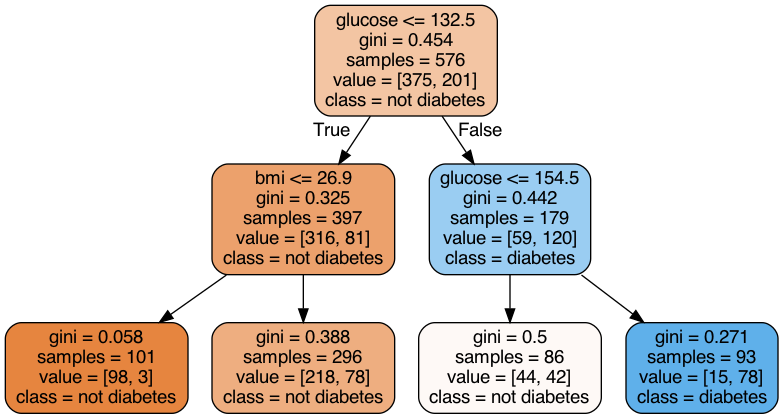

In [31]:
display(Image("https://github.com/alu042/DAT158-2022/raw/main/notebooks/assets/decision_tree_diabetes.png", width=90))

At the left child of the root node there are 397 samples, 316 belonging to not diabetes, 81 to diabetes. 

The formula for $G$ gives:

$$G_i = 1 - \left(\left(\frac{316}{397}\right)^2 + \left(\frac{81}{397}\right)^2\right),$$
which is

In [32]:
1 - ((316 / 397) ** 2 + (81 / 397) ** 2)

0.32480378658579134

...which corresponds to what scikit-learn found for this tree.

The information gain at this node with respect to the feature BMI is the Gini impurity at the node minus the Gini impurities of its children, weighted by their relative sizes:

$$0.325 - \bigg(\left(\frac{101}{397}\right)\cdot 0.058 + \left(\frac{296}{397}\right)\cdot 0.388\bigg)$$

which is

In [33]:
0.325 - ((101 / 397) * 0.058 + (296 / 397) * 0.388)

0.020954659949622145

We can read this as: 
> "if we split the node on the feature BMI, then the information gained is 0.021". 

We want to split nodes in a way that gives very high information gain because that would mean very pure children. This leads us to how decision trees are trained, which we'll study more closely below.

> **Your turn!** Calculate the Gini impurity for the second node in the bottom row (the second leaf).

## Estimating class probabilities

As we discussed when studying logistic regression, having models output predictions *and* estimated probabilities is very useful in practice. We want models that can say things like _"the model predicts that you have diabetes with 74% probability"_.

Decision trees are able to do this.

The idea is simple: when an instance is fed to the decision tree, it goes through some path until it ends up at a leaf node. The fraction of each class associated with that leaf is a probability, and we can interpret it as the probability of belonging to each class.

For example, looking at our above tree again, 

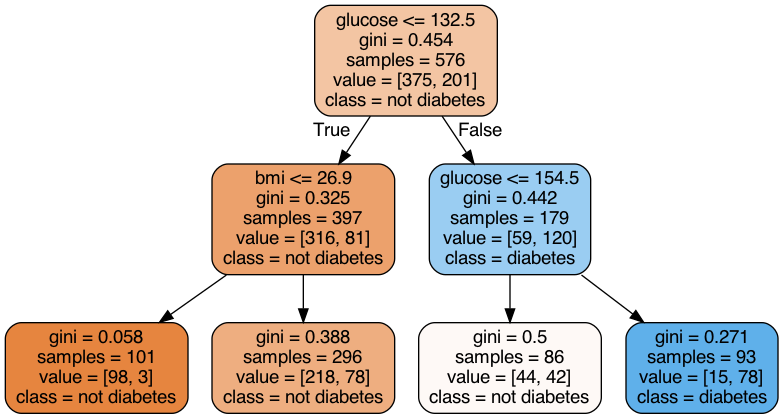

In [34]:
display(
    Image("https://github.com/alu042/DAT158-2022/raw/main/notebooks/assets/decision_tree_diabetes.png", width=90))

an instance with glucose level 100 and BMI 35 ends up in the second leaf node. There are 218 not diabetes and 78 diabetes training instances in that node, and the model will spit out the probabilities

$$218/296 = 0.736, \qquad 78/296 = 0.264$$

for not diabetes and diabetes.

Let's try it out:

In [35]:
test_sample = [100, 35]

We use `predict_proba` to get the probabilities:

In [36]:
tree_clf.predict_proba([test_sample, ])

array([[0.73648649, 0.26351351]])

This seems nice, but it gets less nice once you realise that this method would produce the exact same probabilities for an instance whose glucose is 20 and BMI is 10...

In [37]:
tree_clf.predict_proba([[20, 28], ])

array([[0.73648649, 0.26351351]])

> **Your turn!** Calculate the probability for not diabetes for an instance with glucose level 140 and BMI at 25 by hand. Then do the same using scikit-learn.

# Growing decision trees: The CART algorithm for classification

Decision trees are constructed (that is, trained) using an algorithm that depends on information gain. 

The CART algorithm is one way to grow trees (other alternative algorithms are ID3, C4.5, and C5.0): 

Starting at the root node, the algorithm searches *greedily* for a feature and a threshold (for example, *glucose* and *glucose less than 132.5*) that gives the **highest information gain** when used to split the data. 

<img width=60% src="https://github.com/alu042/DAT158-2022/raw/main/notebooks/assets/information_gain_georgia.PNG"><br><center><small>Image from Georgia Tech</small></center>

Once it has split the training data in two at the root, it continues in the same way on each of the two subsets. 

## Cost function

If we write $f$ for feature and $t_k$ for threshold, the cost function that CART tries to minimize is **the node impurity**:

$$J(f, t_k) = \frac{m_{\mbox{left}}}{m} G_{\mbox{left}} + \frac{m_{\mbox{right}}}{m} G_{\mbox{right}}, $$

where $m$ is the total number of samples in the node and $m_{\mbox{left}}$, $m_{\mbox{right}}$ the number of samples in the left and right child. 

The algorithm stops once it reaches the `max_depth` or if it's impossible to find more splits that reduce the impurity. Or when another stopping criterium, for example a minimum number of samples allowed in the nodes, is reached. 

# Regularization: preventing overfitting

If you put no constraints on the decision trees, they will very quickly produce very complex decision boundaries, which leads to overfitting. In fact, if you let the trees grow until all the leaves are *pure*, i.e., consisting of data points that are all of the same class, then the decision tree will be 100% accurate on the training set. That's typically not good...

Let's see this in action on our data set:

## Overfitting the diabetes data set

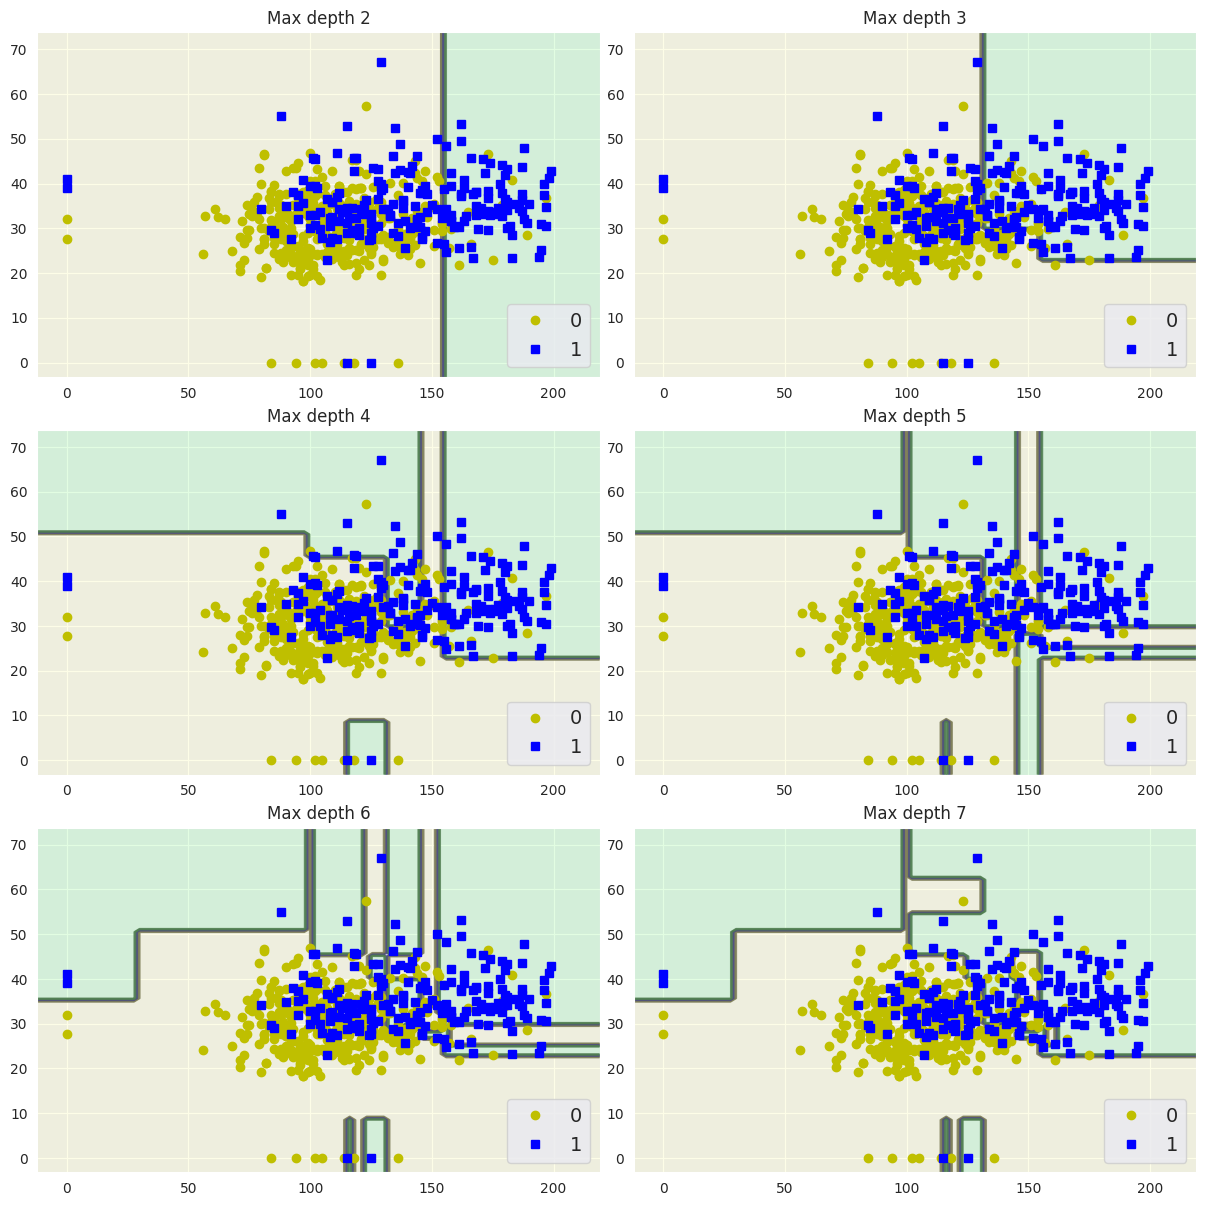

In [38]:
f, axes = plt.subplots(3, 2, figsize=(12, 12))
max_depths = [2, 3, 4, 5, 6, 7]

for i, ax in enumerate(axes.flat):
    tree_clf = DecisionTreeClassifier(max_depth=max_depths[i])
    tree_clf.fit(X_train, y_train)
    _ = plot_decision_boundary(tree_clf, X_train, y_train, ax=ax)
    ax.set_title(f'Max depth {max_depths[i]}')
    plt.tight_layout(pad=0.5)

We see that already with `max_depth` set to 4, the decision tree seems to be overfitting pretty badly. This gets even worse if you have more complicated data sets. 

> **Question for you:** How would you go about finding a good setting for `max_depth`?

## Regularization: controlling the complexity

Restricting models can be used to reduce their variance and, therefore, their tendency to overfit. This is called **regularization**.

In decision trees, the following parameters can be used for regularization:

- **`Max_depth`:** As we saw above, by reducing the maximum depth a decision tree is allowed to have, one can simplify the decision boundary and therefore prevent overfitting. Decrease to regularize.
- **`min_samples_split`**: This parameter controls the minimum number of samples a node can have to be allowed to split. Increase to regularize.
- **`min_samples_leaf`**: The minimum number of samples a leaf must contain. Increase to regularize.
- **`max_features`**: The maximum number of features that are evaluated when deciding whether to split each node. Decrease to regularize.
- **`max_leaf_nodes`**: The maximum number of leaf nodes. Decrease to regularize.
- **`min_impurity_decrease`**: Split nodes if the split results in a decrease of the impurity greater than or equal to this value. Increase to regularize.
- **`min_impurity_split`**: Split a node if its impurity is above this threshold. Otherwise, it's a leaf. Decrease to regularize.

We can play around with some of these parameters on a data set:

In [39]:
from sklearn.datasets import make_moons  # A simple toy data set

Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=42)

In [40]:
tree_clf_noreg = DecisionTreeClassifier()
tree_clf_noreg.fit(Xm, ym)

tree_clf_reg = DecisionTreeClassifier(max_depth=2)  # Try out different settings here
tree_clf_reg.fit(Xm, ym)

DecisionTreeClassifier(max_depth=2)

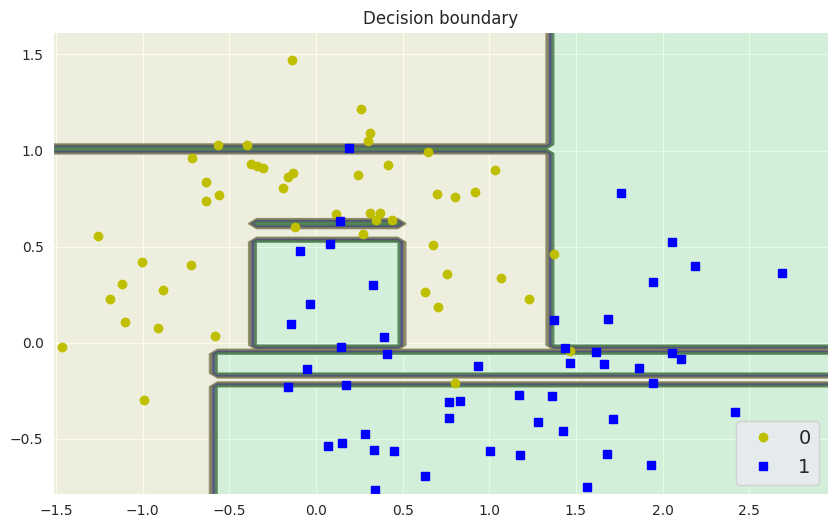

In [41]:
_ = plot_decision_boundary(tree_clf_noreg, Xm, ym)

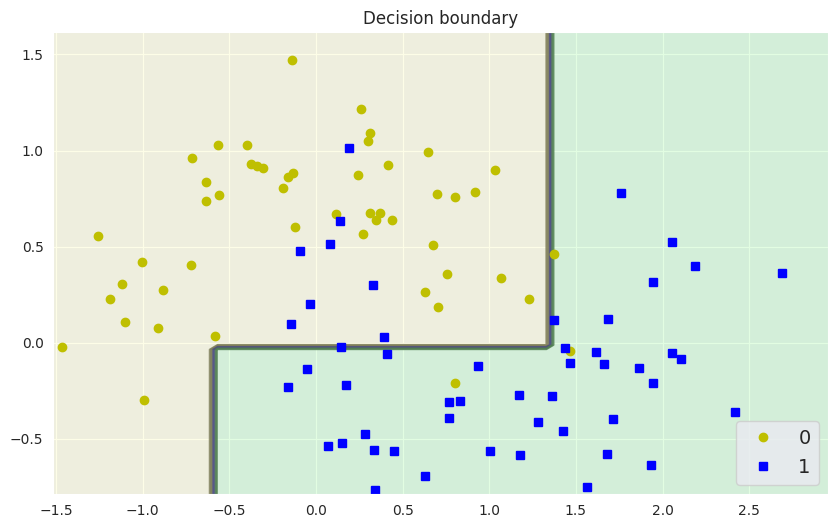

In [42]:
_ = plot_decision_boundary(tree_clf_reg, Xm, ym)

Let's make it interactive:

In [43]:
from ipywidgets import interactive, IntSlider

In [44]:
def make_decision_tree(max_depth, min_samples_leaf):
    tree_clf = DecisionTreeClassifier(max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf,
                                      )

    tree_clf.fit(Xm, ym)

    _ = plot_decision_boundary(tree_clf, Xm, ym)

    plt.show()

In [45]:
interactive_plot = interactive(make_decision_tree,
                               max_depth=IntSlider(min=1, max=15, step=1, value=2),
                               min_samples_leaf=IntSlider(min=1, max=15, value=None)
                               )
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=2, description='max_depth', max=15, min=1), IntSlider(value=1, descripti…

> Feel free to play around also with other parameter settings.

> In practice, it's typically enough to use *one* of `max_depth`, `max_leaf_nodes` or `min_samples_leaf` to prevent overfitting. 

# Decision trees for regression

Decision trees can also be used for regression, in a similar way as for classification. The idea is to use mean squared error (MSE) to measure the impurity of the nodes, and make splits based on MSE. 

Let's try it out on the California Housing Dataset built into scikit-learn:

In [46]:
from sklearn.tree import DecisionTreeRegressor

In [47]:
from sklearn.datasets import fetch_california_housing

In [48]:
housing = fetch_california_housing(as_frame=True)

In [49]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [50]:
housing.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [51]:
X = housing.data
y = housing.target

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [53]:
tree_reg = DecisionTreeRegressor(max_depth=3, random_state=42)

In [54]:
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

**Plotting the tree:**

In [55]:
graph = Source(export_graphviz(tree_reg, out_file=None, feature_names=X.columns,
                               filled=True, rounded=True))

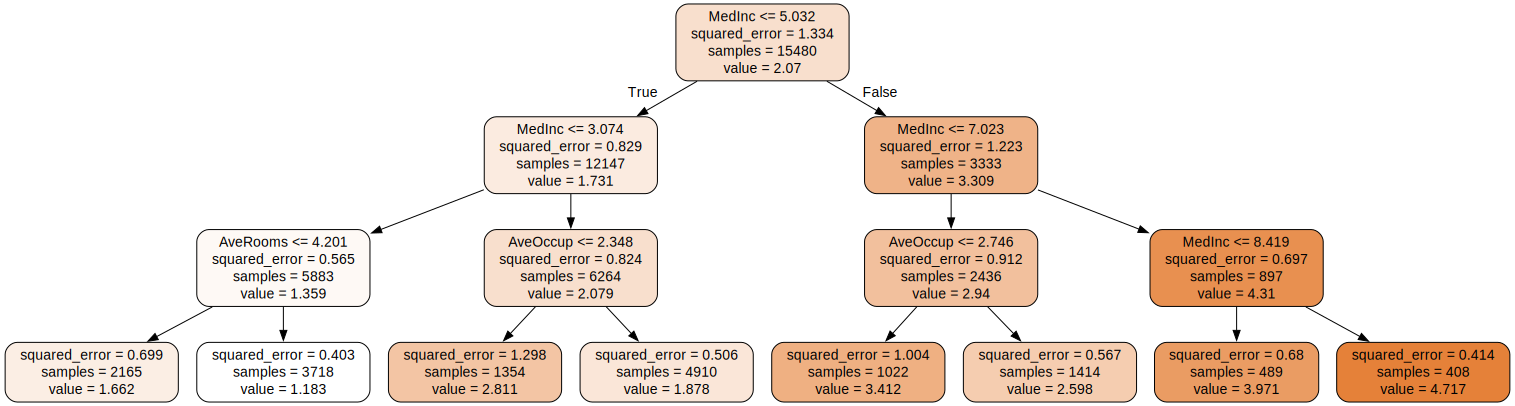

In [56]:
# The following requires graphviz on your computer
display(SVG(graph.pipe(format='svg')))

*Run the below cell if you couldn't get the above plot to work:*

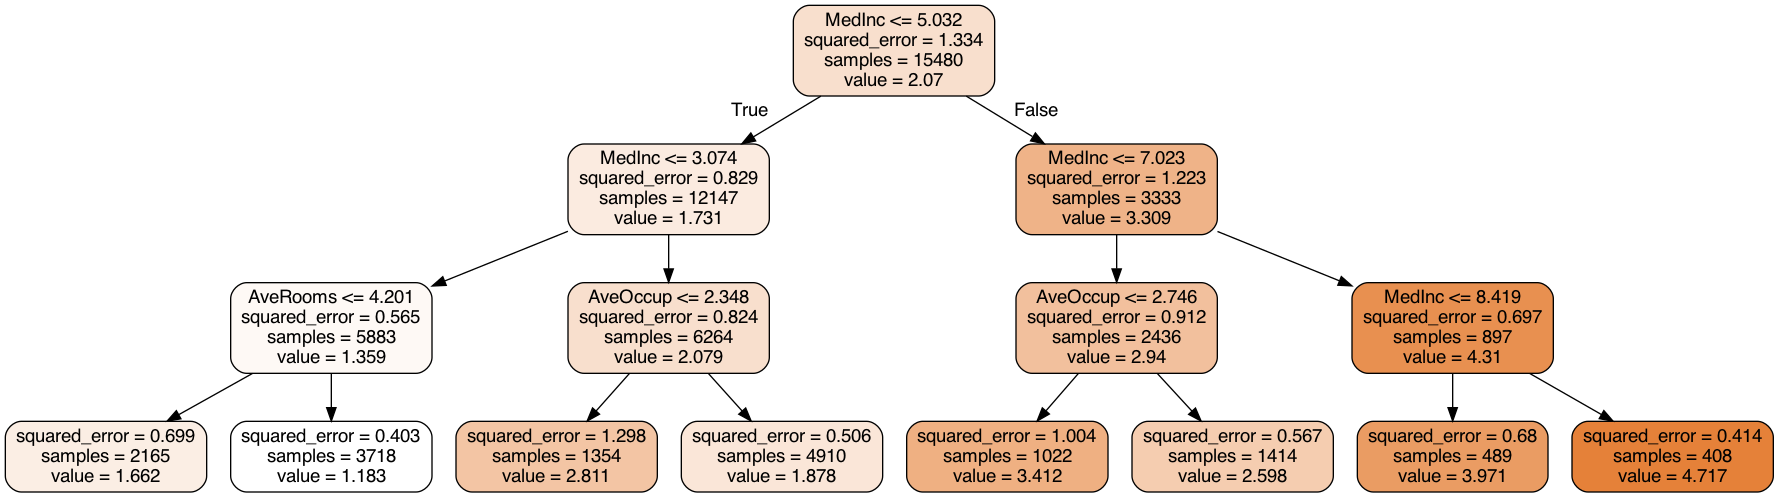

In [57]:
display(Image("https://raw.githubusercontent.com/alu042/DAT158-2022/master/notebooks/assets/decision_tree_housing.png",
              width=90))

When decision trees are used for regression, the nodes are split by minimizing the *mean square error* (MSE) instead of the Gini impurity:

$$\mbox{MSE}(\mbox{node}) = \frac{1}{m_{\mbox{node}}} \sum_{i \in \mbox{node}} \big(y^{(i)} - \hat{y}_{\mbox{node}}\big)^2,$$

where $\hat{y}_{\mbox{node}}$ is the mean target value: $$\hat{y}_{\mbox{node}} = \frac{1}{N_{\mbox{node}}} \sum_{i \in \mbox{node}} y^{(i)}.$$

The cost function becomes:

$$J(f, t_k) = \frac{m_{\mbox{left}}}{m} \mbox{MSE}_{\mbox{left}} + \frac{m_{\mbox{right}}}{m} \mbox{MSE}_{\mbox{right}}$$

> The tree tries to find splits that results in leafs whose target values are on average as close as possible to the mean value of the labels in each leaf.

Let's check how well the model performs by computing the mean square error on the test set:

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [59]:
y_pred = tree_reg.predict(X_test)

In [60]:
mean_squared_error(y_test, y_pred)

0.640829077514131

In [61]:
mean_absolute_error(y_test, y_pred)

0.6001895862815657

### Feature importances

A nice thing about decision trees is that we can easily figure out which features were most important in its predicitions:

In [62]:
tree_reg.feature_importances_

array([0.85265964, 0.        , 0.02839914, 0.        , 0.        ,
       0.11894122, 0.        , 0.        ])

In [63]:
importances = tree_reg.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(indices)):
    print(f'{housing["feature_names"][indices[f]]}: {np.round(importances[indices[f]], 2)}')

MedInc: 0.85
AveOccup: 0.12
AveRooms: 0.03
Longitude: 0.0
Latitude: 0.0
Population: 0.0
AveBedrms: 0.0
HouseAge: 0.0


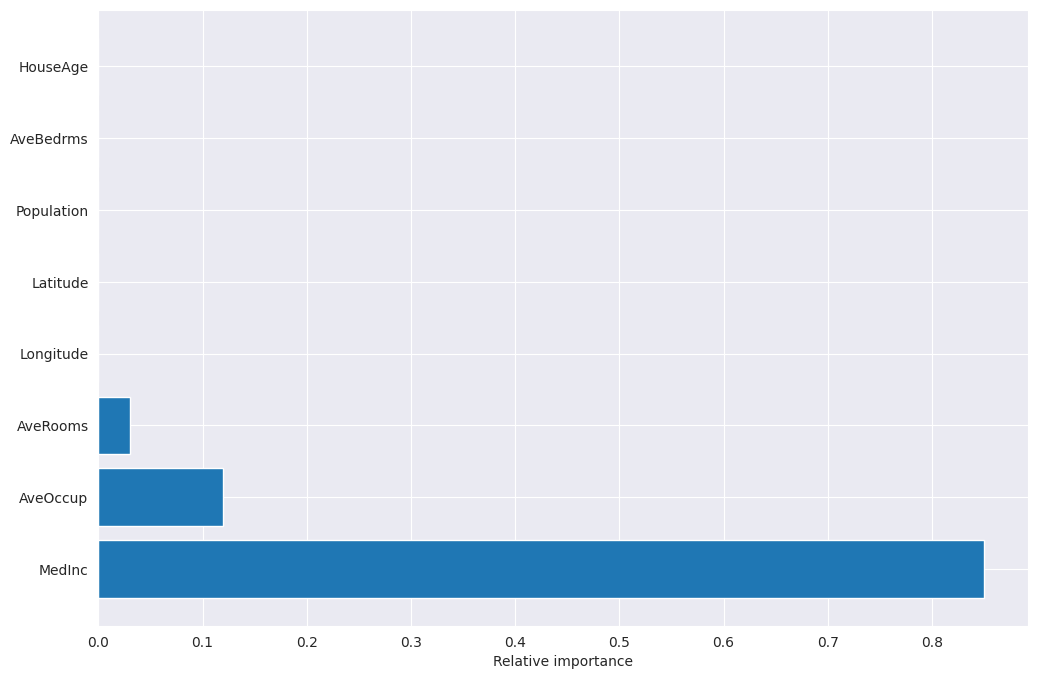

In [64]:
f, ax = plt.subplots(figsize=(12, 8))
plt.barh(X_train.columns[indices], np.round(importances[indices], 2))
plt.xlabel("Relative importance")
plt.show()

**WARNING:** The importance of the different features can be quite random. That a feature is low in importance for this tree doesn't necessarily mean that it's an uninformative feature! The decision tree just didn't pick that feature. Either because it found that another feature in the data set encoded the same information better. Which could happen by chance, since decision trees are quite unstable...

> How are the feature importances calculated? It's the normalized impurity decrease caused by each feature. See the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_">documentation</a>.

**What is a better way to find the importance of features?** We'll look at this question later in the Module.

# Instability. The downsides of using decision trees..

As you've realized by now, decision trees are great machine learning models in many ways. They are 
- easy to use (they work for any combination of categorical and continuous features, without the need for scaling or other pre-processing), 
- easily interpretable (explaining why a decision tree made a decision is simply a matter of retracing the steps taken by the data through the tree. The possibility of computing feature importances is also super handy for interpretability.), 
- and can easily fit the training data. 

However, they have some significant downsides. We've seen that they tend to overfit heavily if not regularized. They are also susceptible to slight variations in the training data.

We can see this in action: by changing the random state in our split of diabetes into train and test, we obtain different trees. Unfortunately, this also influences the feature importances, making them less useful in practice.

In [65]:
data = diabetes[['glucose', 'bmi', 'diabetes']]
X = data[['glucose', 'bmi']]
y = data['diabetes']

In [66]:
def visualize_tree(seed=42):
    """
    Trains a tree on the diabetes data set and plots it using graphviz.
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed)  # Note the seed

    tree_clf = DecisionTreeClassifier(max_depth=2, random_state=1)

    tree_clf.fit(X_train, y_train)

    graph = Source(export_graphviz(tree_clf, out_file=None, feature_names=X.columns,
                                   class_names=['not diabetes', 'diabetes'], filled=True, rounded=True))

    display(SVG(graph.pipe(format='svg')))

    glucose_importance, bmi_importance = tree_clf.feature_importances_
    print(f'Feature importances: Glucose: {glucose_importance}, BMI: {bmi_importance}')

*If the below plots don't work, run the cell below them*

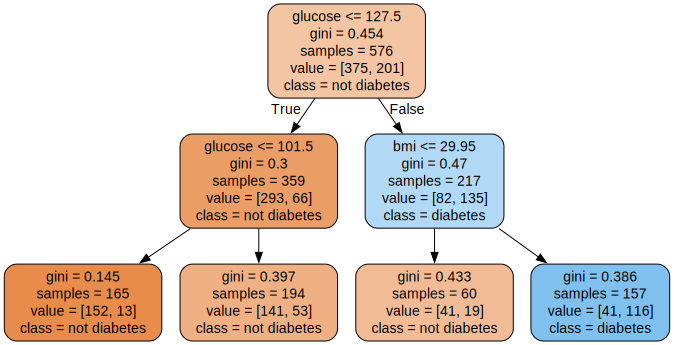

Feature importances: Glucose: 0.7913671536504815, BMI: 0.2086328463495186


In [67]:
visualize_tree(1)

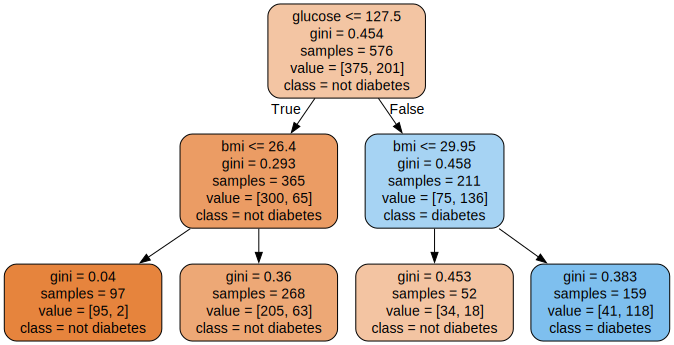

Feature importances: Glucose: 0.7554118248257008, BMI: 0.24458817517429923


In [68]:
visualize_tree(2)

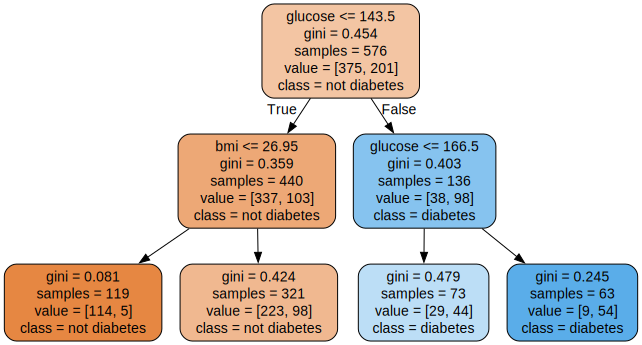

Feature importances: Glucose: 0.8165033057505556, BMI: 0.18349669424944431


In [69]:
visualize_tree(3)

If the above plots didn't work, run the below cells:

In [70]:
#display(Image("https://raw.githubusercontent.com/alu042/DAT158-2022/master/notebooks/assets/decision_tree_diabetes_1.png", width='90%'))

In [71]:
#display(Image("https://raw.githubusercontent.com/alu042/DAT158-2022/master/notebooks/assets/decision_tree_diabetes_2.png", width='90%'))

In [72]:
#display(Image("https://raw.githubusercontent.com/alu042/DAT158-2022/master/notebooks/assets/decision_tree_diabetes_3.png", width='90%'))

To combat these limitations while retaining as many of the nice aspects of decision trees as possible, one usually *ensembles* multiple decision trees into a single model. We'll discuss one way to do this, called **random forests**, in the next notebook. 

# Extra

> **Your turn!**
- Train a decision tree classifier on the breast cancer wisconsin dataset (`sklearn.datasets.load_breast_cancer`), with `max-depth` set to 3 or 4.
- Make a training, validation and test set to figure out which one seems better, `max_depth` 3 or 4?
- Test your choice on the test set. You should get an accuracy of about 95%
- Plot the decision tree.
- Plot the decision boundaries for different pairs of features.
- Use `tree_clf.feature_importances_` to find which features were most important for the classification when using all the features.

You should find a tree similar to: 

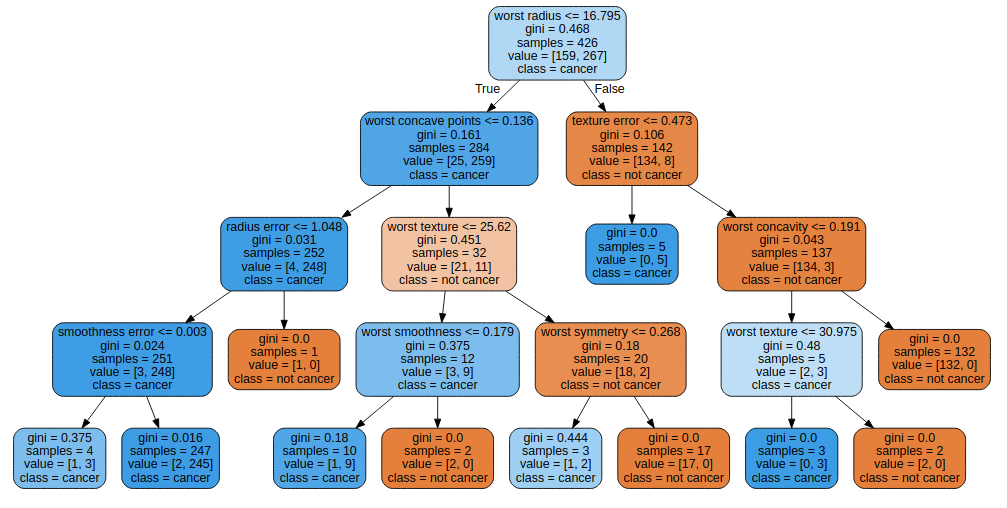

In [73]:
display(Image("https://raw.githubusercontent.com/alu042/DAT158-2022/master/notebooks/assets/decision_tree_cancer.png",
              width=90))

**Extra resources:**
> Scikit-learns documentation for decision trees is very useful. You should have a look: http://scikit-learn.org/stable/modules/tree.html.

> `dtreeeviz` is a nice library for visualizing decision trees: http://explained.ai/decision-tree-viz